# Image classification

Back in 2017 when I first tried fast.ai, the "hello world" of image classification was how to classify cats versus dogs. That task is now too easy for modern approaches, and won't allow us to explore the nuances in model training.

The task in this notebook consists of classifying 13 pet breeds from images, which is a substantially more difficult problem.

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [2]:
Path.BASE_PATH = path # display paths relative to BASE_PATH

In [3]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [4]:
(path/"images").ls()

(#7393) [Path('images/Sphynx_185.jpg'),Path('images/japanese_chin_111.jpg'),Path('images/Ragdoll_166.jpg'),Path('images/boxer_96.jpg'),Path('images/Maine_Coon_27.jpg'),Path('images/japanese_chin_3.jpg'),Path('images/american_pit_bull_terrier_190.jpg'),Path('images/pomeranian_94.jpg'),Path('images/wheaten_terrier_27.jpg'),Path('images/great_pyrenees_100.jpg')...]

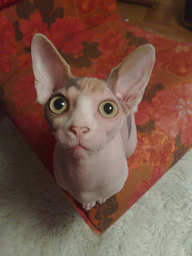

In [5]:
im = Image.open(path/'images'/'Sphynx_185.jpg')
im.to_thumb(256)

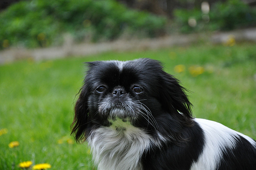

In [6]:
im = Image.open(path/'images'/'japanese_chin_111.jpg')
im.to_thumb(256)

So `./images` contains 7393 images of pets, where the breed is in the file name. If the first letter is upper-case, it's a cat. If the first letter is lower-case, it's a dog.

In [7]:
(path/"annotations").ls()

(#7) [Path('annotations/test.txt'),Path('annotations/._trimaps'),Path('annotations/README'),Path('annotations/list.txt'),Path('annotations/trainval.txt'),Path('annotations/xmls'),Path('annotations/trimaps')]

## Build a datablock

In [8]:
get_pet_label = lambda s: re.findall(r'(.+)_\d+\.jpg$', s.name)[0]

In [9]:
get_pet_label((path/'images').ls()[1])

'japanese_chin'

In [11]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # the independent and dependent variable types
    get_items=get_image_files, # how to get a list of image files -- in this case from folders in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # how to partition the data into training/validation sets
    get_y=get_pet_label, # how to get the target -- in this case from a regular expression
    # alternatively:
    #get_y=using_attr(RegexLabeller(r'(.+)_\d+\.jpg$'), 'name'),
    item_tfms=Resize(460), # transformations to apply to the data before handing to the GPU
    batch_tfms=aug_transforms(size=224, min_scale=0.75) # transformations to apply to the data after handing to the GPU. Data augmentation.
)

### Aside: Presizing

`item_tfms=Resize(460)` resizes the image to quite a large random square image (460x460). `batch_tfms=...` uses `RandomResizeCrop` in the `size=224` argument to output an augmented square image which is 224x224.

The first step is used so that the image augmentation can take place on the GPU.

Fastai's implementation of image augmentation is also performed in a less lossy way, by applying the desired transformations only once, and then interpolated only once. Most other deep learning libraries perform interpolation at each step of the augmentation, which damages image quality.

In [12]:
dls = pets.dataloaders(path/'images')

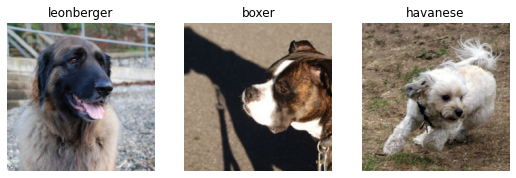

In [13]:
dls.valid.show_batch(nrows=1, ncols=3)

To inspect the image augmentation:

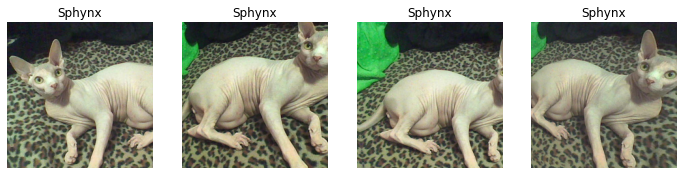

In [14]:
dls.show_batch(nrows=1, ncols=4, unique=True)

In [15]:
# # This line will print out progress in building the DataBlock. Useful for debugging.
# pets.summary(path/'images')

Tip: Instead of spending loads of time data cleaning, build a model as soon as you have a `dataloaders`. A model will help understand where the data are dirty.

In [16]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.522712,0.337261,0.108254,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.490162,0.307039,0.105548,00:42
1,0.301122,0.227654,0.077808,00:42


In [18]:
interp = ClassificationInterpretation.from_learner(learn)

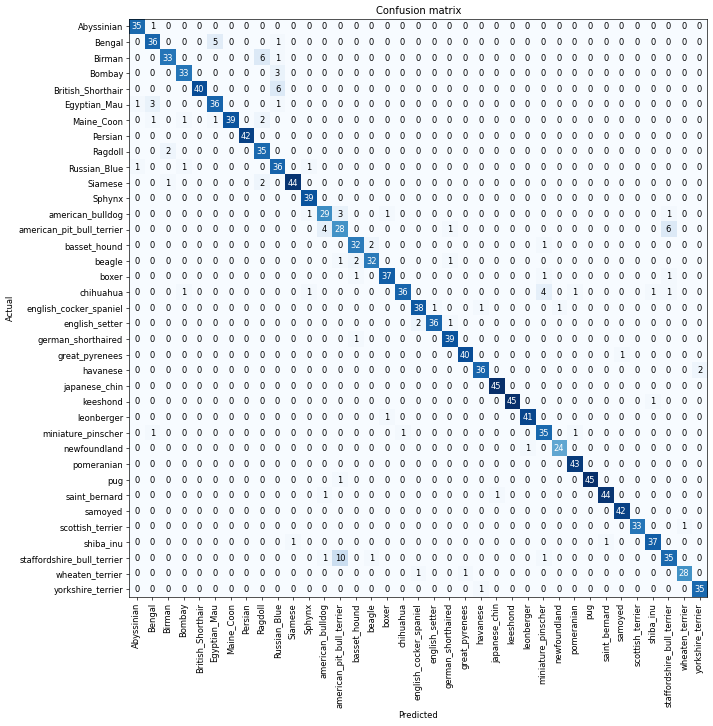

In [54]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

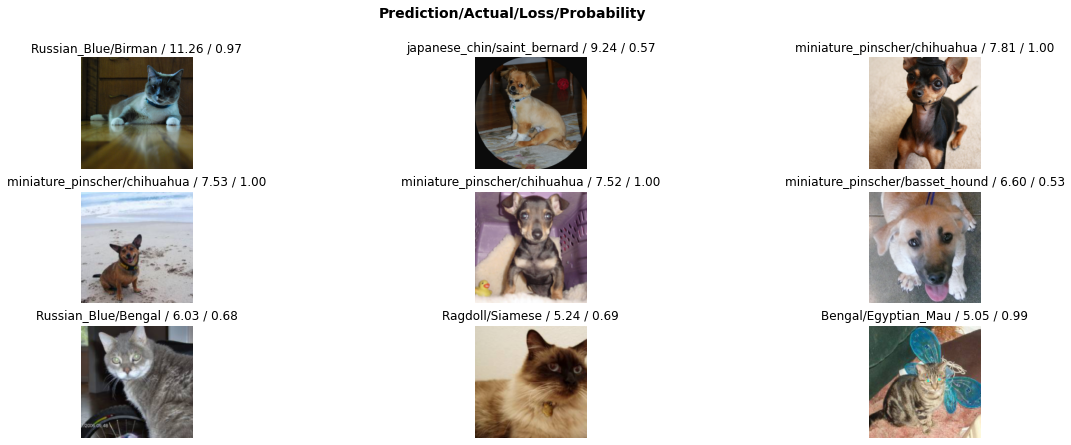

In [19]:
interp.plot_top_losses(9, nrows=3, ncols=3, figsize=(20,7))

The loss function fastai decided to use was:

In [20]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Aside: Softmax, Negative Log Likelihood and Cross Entropy

Consider a neural network with 3 activations in the final layer, e.g.

In [21]:
acts = torch.randn((6,3))*2  # activations

In [22]:
acts

tensor([[ 1.7275,  2.9100,  0.0697],
        [-3.5405,  2.3619,  3.3812],
        [-1.0636, -3.0229,  2.7706],
        [ 0.4199,  0.8443,  0.4454],
        [ 1.2492, -0.2921,  2.0771],
        [-1.2909,  1.0964, -1.6134]])

We can normalize these activations such that the class categories sum to 1 using a softmax function

In [39]:
sm_acts = torch.softmax(acts, dim=1)

In [40]:
sm_acts

tensor([[2.2456e-01, 7.3265e-01, 4.2792e-02],
        [7.2414e-04, 2.6497e-01, 7.3431e-01],
        [2.1097e-02, 2.9740e-03, 9.7593e-01],
        [2.8134e-01, 4.3007e-01, 2.8860e-01],
        [2.8551e-01, 6.1124e-02, 6.5337e-01],
        [7.9311e-02, 8.6324e-01, 5.7449e-02]])

In [41]:
sm_acts.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

The advantage of using a softmax in classification is that the use of exponential functions results in the output being very sensitive to the activations, so the model will tend to pick just one class as the prediction.

Say that the target (i.e. the corresponding data labels for each activation) is the following tensor

In [25]:
targ = tensor([2,0,1,1,2,0])  # known labels from training data

The negative log likelihood is simply (-1) times the predicted (log) probability of the true label. The (-1) is because we want to minimize this value

In [26]:
idx = range(len(targ))

In [42]:
-sm_acts[idx, targ]

tensor([-0.0428, -0.0007, -0.0030, -0.4301, -0.6534, -0.0793])

In [43]:
F.nll_loss(sm_acts, targ, reduction='none')  # nll_loss doesn't actually do a log, for computational reasons, see below

tensor([-0.0428, -0.0007, -0.0030, -0.4301, -0.6534, -0.0793])

Mathematically, the NLL is the (mean of the) log probabilities of the data class (times -1)

<img src="./figures/nll.png" style="width:700px"> 

`reduction` in `nll_loss` allows you to choose other kinds of summaries of the negative log likelihood, besides the mean. The picture above uses a sum. `reduction='none'` shows the NLL for all the data examples.

In PyTorch, `nll_loss` doesn't actually implement the log itself -- it assumes that the activations have already been passed through a softmax. This confusing name is because PyTorch has a fast, accurate, implementation of `log(softmax(x))` called `log_softmax`. So `nll_loss` is designed to be used after `log_softmax`. So `nll_loss` doesn't actually compute NLL!

The combination `NLL(log(softmax(x)), target)` is called the [**cross-entropy loss**](https://en.wikipedia.org/wiki/Cross_entropy), and is a sensitive, smooth, loss function appropriate for classification.

In [30]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([3.1514, 7.2305, 5.8178, 0.8438, 0.4256, 2.5344])

In [52]:
-sm_acts[idx, targ].log()

tensor([3.1514, 7.2305, 5.8178, 0.8438, 0.4256, 2.5344])

In [50]:
F.nll_loss(F.log_softmax(acts, dim=1), targ, reduction='none')

tensor([3.1514, 7.2305, 5.8178, 0.8438, 0.4256, 2.5344])